In this dataset, you are provided with game analytics for the PBS KIDS Measure Up! app. In this app, children navigate a map and complete various levels, which may be activities, video clips, games, or assessments. Each assessment is designed to test a child's comprehension of a certain set of measurement-related skills. There are five assessments: Bird Measurer, Cart Balancer, Cauldron Filler, Chest Sorter, and Mushroom Sorter.

The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt). Each application install is represented by an installation_id. This will typically correspond to one child, but you should expect noise from issues such as shared devices. In the training set, you are provided the full history of gameplay data. In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

### insight

In [1]:
import pandas as pd
#import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
path = './001.data/'

### user func

In [3]:
def info_df(data):
    '''
    data의 type, null_count, null_rate를 알려주는 함수 
    추가로 unique한 데이터의 수를 알려줌 (속도가 느리므로 손도 필요시 주석처리 필요)
    '''
    info_df = pd.DataFrame({"type":data.dtypes,
                            'null_count':data.isnull().sum(),
                           'null_rate':data.isnull().sum()/data.isnull().count() * 100})
    
    cols = data.columns.values
    
    uni_count =[]
    for col in cols:
        uni_count.append(len(data[col].unique()))
    info_df['uni_count'] = uni_count
    
    return info_df

In [4]:
import re
def clean_colname(data):
    new_col=[]
    for i in data.columns.values:
        new_col.append(re.sub('[\W]',"",i))
    data.columns = new_col
    return data

### data load

In [5]:
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')
specs_df = pd.read_csv(path + 'specs.csv')
train_labels_df = pd.read_csv(path +'train_labels.csv')

In [6]:
train_df.shape, test_df.shape, specs_df.shape,train_labels_df.shape

((11341042, 11), (1156414, 11), (386, 3), (17690, 7))

### data check
* NA 없음

In [7]:
train_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [8]:
info_df(train_df)

,type,null_count,null_rate,uni_count
event_id,object,0,0.0,384
game_session,object,0,0.0,303319
timestamp,object,0,0.0,10777308
event_data,object,0,0.0,10893749
installation_id,object,0,0.0,17000
event_count,int64,0,0.0,3368
event_code,int64,0,0.0,42
game_time,int64,0,0.0,834048
title,object,0,0.0,44
type,object,0,0.0,4


In [9]:
test_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [10]:
info_df(test_df)

,type,null_count,null_rate,uni_count
event_id,object,0,0.0,365
game_session,object,0,0.0,28445
timestamp,object,0,0.0,1103166
event_data,object,0,0.0,1120854
installation_id,object,0,0.0,1000
event_count,int64,0,0.0,4456
event_code,int64,0,0.0,42
game_time,int64,0,0.0,309119
title,object,0,0.0,44
type,object,0,0.0,4


In [11]:
specs_df.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [12]:
info_df(specs_df)

,type,null_count,null_rate,uni_count
event_id,object,0,0.0,386
info,object,0,0.0,168
args,object,0,0.0,191


In [13]:
train_labels_df.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [14]:
info_df(train_labels_df)

,type,null_count,null_rate,uni_count
game_session,object,0,0.0,17690
installation_id,object,0,0.0,3614
title,object,0,0.0,5
num_correct,int64,0,0.0,2
num_incorrect,int64,0,0.0,46
accuracy,float64,0,0.0,30
accuracy_group,int64,0,0.0,4


### Simple EDA

In [15]:
train_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [16]:
info_df(train_df)

,type,null_count,null_rate,uni_count
event_id,object,0,0.0,384
game_session,object,0,0.0,303319
timestamp,object,0,0.0,10777308
event_data,object,0,0.0,10893749
installation_id,object,0,0.0,17000
event_count,int64,0,0.0,3368
event_code,int64,0,0.0,42
game_time,int64,0,0.0,834048
title,object,0,0.0,44
type,object,0,0.0,4


### event_id

In [17]:
frame_length = len(train_df)
event_id_length = len(train_df.event_id.unique())
print("data length:",frame_length)
print("unique event_id:",event_id_length)

data length: 11341042
unique event_id: 384


In [18]:
train_df.event_id.value_counts().head()

1325467d    274673
bb3e370b    256179
cf82af56    224694
5e812b27    206129
cfbd47c8    199734
Name: event_id, dtype: int64

### game_session

In [19]:
game_session_length = len(train_df.game_session.unique())
print("data length:",frame_length)
print("unique game_session_length:",game_session_length)

data length: 11341042
unique game_session_length: 303319


In [20]:
train_df.game_session.value_counts().head()

6e6e697f2e593de1    3368
bb1f09ec062b6660    3182
33495c8f126e2ef9    2505
34c82b23355e378c    2456
8fe0ab3c3e448a04    2398
Name: game_session, dtype: int64

### timestamp
* 2019-09-06T17:53:46.937Z what is Z?
* 2019-09-06/ 17:53:46/ 937Z split right this

##### date

In [21]:
train_df['date'] = train_df['timestamp'].apply(lambda x: x.split('T')[0])

In [22]:
print("max_count day:", train_df['date'].value_counts().idxmax(),"max_count:",train_df['date'].value_counts().max())
print("min_count day:", train_df['date'].value_counts().idxmin(),"min_count:",train_df['date'].value_counts().min())

max_count day: 2019-09-27 max_count: 200217
min_count day: 2019-10-22 min_count: 41


In [23]:
#the data strated at 2019-07-23, and ended at 2019-10-22
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['date'].describe()

count                11341042
unique                     85
top       2019-09-27 00:00:00
freq                   200217
first     2019-07-23 00:00:00
last      2019-10-22 00:00:00
Name: date, dtype: object

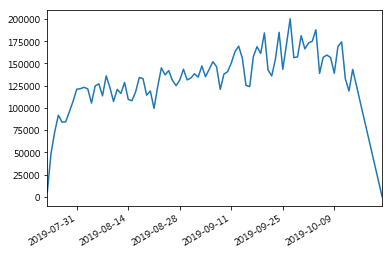

In [24]:
# lastday count going down 
train_df['date'].value_counts().sort_index().plot()
plt.show()

##### time

In [25]:
train_df['time'] = train_df['timestamp'].apply(lambda x: x.split('T')[1].split('.')[0])

In [26]:
train_df['hour'] = train_df['time'].apply(lambda x: int(x[0:2]))

In [27]:
train_df['hour'].value_counts().head()

19    899390
17    882818
18    875299
16    824005
15    819824
Name: hour, dtype: int64

In [28]:
train_df['hour'].value_counts().tail()

10    63710
6     46696
7     26340
8     22636
9     22216
Name: hour, dtype: int64

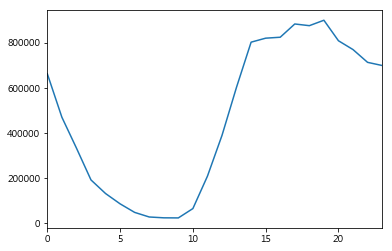

In [29]:
# little bit  weird minnight time are still popular
train_df['hour'].value_counts().sort_index().plot()
plt.show()

In [30]:
train_df['time'] = pd.to_timedelta(train_df['time'])

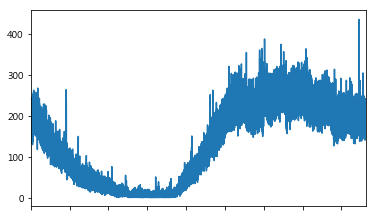

In [31]:
# seem like moring isn't popular but evening is pop
train_df['time'].value_counts().sort_index().plot()
plt.show()

#### Z?
* seems like location -> NOPE 3 type of Z are similar
* 정답은 초(seconds)

In [32]:
train_df['timestampe_Z'] = train_df['timestamp'].apply(lambda x: x.split('.')[1])

In [33]:
train_df['timestampe_Z'].value_counts().head()

299Z    23221
332Z    23087
105Z    23061
184Z    23051
210Z    23013
Name: timestampe_Z, dtype: int64

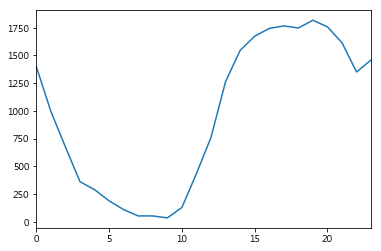

In [34]:
train_df.loc[train_df['timestampe_Z'] == '299Z','hour'].value_counts().sort_index().plot()

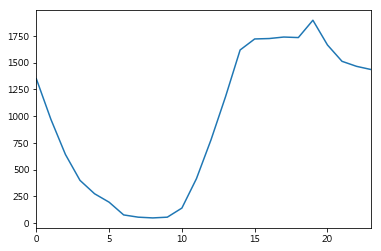

In [35]:
train_df.loc[train_df['timestampe_Z'] == '332Z','hour'].value_counts().sort_index().plot()

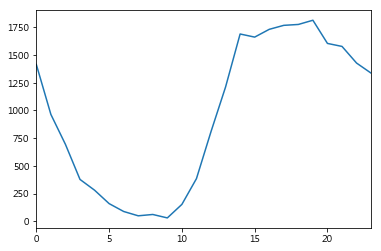

In [36]:
train_df.loc[train_df['timestampe_Z'] == '105Z','hour'].value_counts().sort_index().plot()

### event_data
* quite dificult to handle 
* the longest one's lenght is 18061!
* the important things are maybe : event_code, event_count

event_data - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.

In [37]:
train_df.event_data.apply(lambda x : len(x)).idxmax()

6839091

In [38]:
train_df.iloc[6839091]

event_id                                                    b7530680
game_session                                        8fe0ab3c3e448a04
timestamp                                   2019-08-12T18:22:16.033Z
event_data         {"previous_jars":[[{"color":"green","amount":1...
installation_id                                             994491d0
event_count                                                     2391
event_code                                                      2020
game_time                                                    3490639
title                                       Bottle Filler (Activity)
type                                                        Activity
world                                                      MAGMAPEAK
date                                             2019-08-12 00:00:00
time                                                 0 days 18:22:16
hour                                                              18
timestampe_Z                      

In [39]:
train_df.iloc[6839091-30:6839091]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,time,hour,timestampe_Z
6839061,15a43e5b,8fe0ab3c3e448a04,2019-08-12T18:21:32.447Z,"{""coordinates"":{""x"":936,""y"":605,""stage_width"":...",994491d0,2360,4070,3447041,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-12,18:21:32,18,447Z
6839062,15a43e5b,8fe0ab3c3e448a04,2019-08-12T18:21:33.321Z,"{""coordinates"":{""x"":930,""y"":618,""stage_width"":...",994491d0,2361,4070,3447917,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-12,18:21:33,18,321Z
6839063,df4940d3,8fe0ab3c3e448a04,2019-08-12T18:21:35.993Z,"{""description"":""And it's full! I'll put this o...",994491d0,2362,3110,3450608,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-12,18:21:35,18,993Z
6839064,e9c52111,8fe0ab3c3e448a04,2019-08-12T18:21:37.184Z,"{""jar"":[{""color"":""yellow"",""amount"":1},{""color""...",994491d0,2363,2030,3451801,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-12,18:21:37,18,184Z
6839065,b7530680,8fe0ab3c3e448a04,2019-08-12T18:21:37.186Z,"{""previous_jars"":[[{""color"":""green"",""amount"":1...",994491d0,2364,2020,3451801,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-12,18:21:37,18,186Z
6839066,bb3e370b,8fe0ab3c3e448a04,2019-08-12T18:21:38.960Z,"{""bottle"":{""amount"":1,""color"":""green""},""bottle...",994491d0,2365,4030,3453552,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-12,18:21:38,18,960Z
6839067,67439901,8fe0ab3c3e448a04,2019-08-12T18:21:39.625Z,"{""description"":""That looks so cool!"",""identifi...",994491d0,2366,3010,3454241,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-12,18:21:39,18,625Z
6839068,90efca10,8fe0ab3c3e448a04,2019-08-12T18:21:39.627Z,"{""bottle"":{""amount"":1,""color"":""green""},""bottle...",994491d0,2367,4020,3454241,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-12,18:21:39,18,627Z
6839069,df4940d3,8fe0ab3c3e448a04,2019-08-12T18:21:42.262Z,"{""description"":""That looks so cool!"",""identifi...",994491d0,2368,3110,3456876,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-12,18:21:42,18,262Z
6839070,bb3e370b,8fe0ab3c3e448a04,2019-08-12T18:21:43.056Z,"{""bottle"":{""amount"":2,""color"":""green""},""bottle...",994491d0,2369,4030,3457643,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-12,18:21:43,18,056Z


In [40]:
train_df.event_data.iloc[6839064,]

'{"jar":[{"color":"yellow","amount":1},{"color":"yellow","amount":2}],"duration":15549,"round":218,"event_count":2363,"game_time":3451801,"event_code":2030}'

In [41]:
train_df.event_data.iloc[6839065,]

'{"previous_jars":[[{"color":"green","amount":1},{"color":"green","amount":2},{"color":"yellow","amount":2}],[{"color":"yellow","amount":1},{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"yellow","amount":1},{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"yellow","amount":1},{"color":"yellow","amount":2},{"color":"orange","amount":2}],[{"color":"yellow","amount":2},{"color":"yellow","amount":1}],[{"color":"green","amount":1},{"color":"green","amount":2},{"color":"blue","amount":1}],[{"color":"pink","amount":1},{"color":"pink","amount":2}],[{"color":"pink","amount":1},{"color":"pink","amount":2}],[{"color":"pink","amount":2},{"color":"pink","amount":1}],[{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"pink","amount":2},{"color":"pink","amount":1},{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"orange","amount":1},{"color":"yellow","amount":1},{"color":"yellow","amount":2}],[{"color":"pink","a

In [42]:
len(train_df.event_data.iloc[6839091,])

18061

In [43]:
train_df.event_data.iloc[6839091,]

'{"previous_jars":[[{"color":"green","amount":1},{"color":"green","amount":2},{"color":"yellow","amount":2}],[{"color":"yellow","amount":1},{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"yellow","amount":1},{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"yellow","amount":1},{"color":"yellow","amount":2},{"color":"orange","amount":2}],[{"color":"yellow","amount":2},{"color":"yellow","amount":1}],[{"color":"green","amount":1},{"color":"green","amount":2},{"color":"blue","amount":1}],[{"color":"pink","amount":1},{"color":"pink","amount":2}],[{"color":"pink","amount":1},{"color":"pink","amount":2}],[{"color":"pink","amount":2},{"color":"pink","amount":1}],[{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"pink","amount":2},{"color":"pink","amount":1},{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"orange","amount":1},{"color":"yellow","amount":1},{"color":"yellow","amount":2}],[{"color":"pink","a

In [44]:
for row in train_df.event_data:
    one_list = row.split(',')
    for i in range(0,len(one_list)-1):
        one_list

In [45]:
train_df.event_data.iloc[6839091,]

'{"previous_jars":[[{"color":"green","amount":1},{"color":"green","amount":2},{"color":"yellow","amount":2}],[{"color":"yellow","amount":1},{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"yellow","amount":1},{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"yellow","amount":1},{"color":"yellow","amount":2},{"color":"orange","amount":2}],[{"color":"yellow","amount":2},{"color":"yellow","amount":1}],[{"color":"green","amount":1},{"color":"green","amount":2},{"color":"blue","amount":1}],[{"color":"pink","amount":1},{"color":"pink","amount":2}],[{"color":"pink","amount":1},{"color":"pink","amount":2}],[{"color":"pink","amount":2},{"color":"pink","amount":1}],[{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"pink","amount":2},{"color":"pink","amount":1},{"color":"orange","amount":1},{"color":"orange","amount":2}],[{"color":"orange","amount":1},{"color":"yellow","amount":1},{"color":"yellow","amount":2}],[{"color":"pink","a

In [46]:
train_df.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title',
       'type', 'world', 'date', 'time', 'hour', 'timestampe_Z'],
      dtype='object')

### installation_id

In [47]:
installation_id_length = len(train_df.installation_id.unique())
print("data length:",frame_length)
print("unique event_id:",installation_id_length)

data length: 11341042
unique event_id: 17000


In [48]:
train_df.installation_id.value_counts().head()

f1c21eda    58988
4d7d3d97    32749
d25338cb    31826
cff5a334    30918
c9ea32e9    30402
Name: installation_id, dtype: int64

### event_count

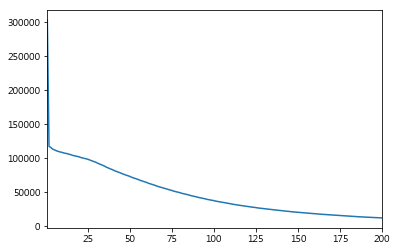

In [49]:
#1회부터 점차 감소하는 경향을 보임
train_df.event_count.value_counts()[0:200].sort_index().plot()
plt.show()

### event_code

Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.

In [50]:
train_df.event_code.value_counts()

4070    2349642
4030    1544814
3010    1368695
3110    1345452
4020    1237789
2020     353006
4035     310875
2030     306032
2000     303319
3020     292655
3120     289230
3021     248370
3121     243732
4025     233083
4021     190783
4040      91879
4100      69640
4022      67102
4010      54698
4031      47176
2040      33743
2080      33497
4230      31535
4235      31526
2050      29691
2083      23091
5000      21998
5010      21541
4045      20166
2025      19987
4220      18777
2060      15770
4095      15587
4090      13724
4110      13608
2010      11696
2035      11196
2081       8403
2070       7654
2075       6925
4050       1989
4080        966
Name: event_code, dtype: int64

### game_time
* default are maybe seconds
* max_game_time can be days

In [51]:
print('max:',train_df.game_time.max())
print('min:',train_df.game_time.min())

max: 306910249
min: 0


In [52]:
train_df.game_time.describe()

count    1.134104e+07
mean     1.976236e+05
std      1.803968e+06
min      0.000000e+00
25%      3.061800e+04
50%      7.276100e+04
75%      1.574460e+05
max      3.069102e+08
Name: game_time, dtype: float64

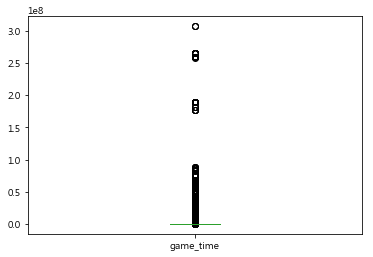

In [53]:
train_df.game_time.plot.box()

### game_time의 고찰
* 단위는 milliseconds임 따라서 1000을 나누면 1초

In [54]:
train_df['game_time_seconds'] = train_df.game_time/1000

In [55]:
train_df['game_time_seconds'].describe()

count    1.134104e+07
mean     1.976236e+02
std      1.803968e+03
min      0.000000e+00
25%      3.061800e+01
50%      7.276100e+01
75%      1.574460e+02
max      3.069102e+05
Name: game_time_seconds, dtype: float64

### game_time이 최장인경우
* 게임시간은 누적합일까? -> installation_id로 확인

In [56]:
#게임시간이 가장긴 index
train_df.game_time.idxmax()

2479711

In [57]:
#가장 오래한 날짜는 2019-08-29
train_df.iloc[train_df.game_time.idxmax()]

event_id                                                      7da34a02
game_session                                          969a6c0d56aa4683
timestamp                                     2019-08-29T23:57:16.621Z
event_data           {"coordinates":{"x":284,"y":686,"stage_width":...
installation_id                                               36bd989b
event_count                                                         45
event_code                                                        4070
game_time                                                    306910249
title                                     Mushroom Sorter (Assessment)
type                                                        Assessment
world                                                      TREETOPCITY
date                                               2019-08-29 00:00:00
time                                                   0 days 23:57:16
hour                                                                23
timest

In [58]:
#가장 오래한 installation_id
train_df.iloc[train_df.game_time.idxmax()]['installation_id']

'36bd989b'

In [59]:
len(train_df.loc[train_df.installation_id == '36bd989b',])

4098

In [60]:
#game_time은 누적되지 않음 2000 login단위로 쪼개짐
train_df.loc[(train_df.installation_id == '36bd989b'),'game_time']

2475787        0
2475788        0
2475789        0
2475790     1475
2475791     6291
2475792     6806
2475793     7410
2475794     7954
2475795     8334
2475796     9302
2475797     9683
2475798    10982
2475799    14138
2475800    14138
2475801    14604
2475802    14901
2475803    15474
2475804    16345
2475805    17027
2475806    18509
2475807    18509
2475808    19233
2475809    19461
2475810    20578
2475811    20578
2475812    21679
2475813    21679
2475814    21822
2475815    23804
2475816    23996
           ...  
2479855        0
2479856        0
2479857     5494
2479858     5942
2479859     6490
2479860     7052
2479861     8038
2479862     9139
2479863     9807
2479864    10427
2479865    11053
2479866    12148
2479867    13362
2479868    13362
2479869    13973
2479870    15313
2479871    15313
2479872    15313
2479873    15313
2479874    15969
2479875    17136
2479876    23259
2479877    23259
2479878    23259
2479879    25698
2479880    27522
2479881    27522
2479882    275

In [61]:
#특정날짜의 데이터
train_df.loc[(train_df.installation_id == '36bd989b')&(train_df.date == '2019-08-15')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,time,hour,timestampe_Z,game_time_seconds
2475787,27253bdc,2ee6b2e08671e912,2019-08-15T23:46:30.634Z,"{""event_code"": 2000, ""event_count"": 1}",36bd989b,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-15,23:46:30,23,634Z,0.000
2475788,27253bdc,7a67c253f9885859,2019-08-15T23:47:15.357Z,"{""event_code"": 2000, ""event_count"": 1}",36bd989b,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-15,23:47:15,23,357Z,0.000
2475789,77261ab5,564b98efaa6bbcd6,2019-08-15T23:47:58.303Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",36bd989b,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-15,23:47:58,23,303Z,0.000
2475790,b2dba42b,564b98efaa6bbcd6,2019-08-15T23:47:59.048Z,"{""description"":""Let's build a sandcastle! Firs...",36bd989b,2,3010,1475,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-15,23:47:59,23,048Z,1.475
2475791,1325467d,564b98efaa6bbcd6,2019-08-15T23:48:03.479Z,"{""coordinates"":{""x"":928,""y"":222,""stage_width"":...",36bd989b,3,4070,6291,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-15,23:48:03,23,479Z,6.291
2475792,1325467d,564b98efaa6bbcd6,2019-08-15T23:48:03.862Z,"{""coordinates"":{""x"":857,""y"":237,""stage_width"":...",36bd989b,4,4070,6806,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-15,23:48:03,23,862Z,6.806
2475793,1325467d,564b98efaa6bbcd6,2019-08-15T23:48:04.471Z,"{""coordinates"":{""x"":571,""y"":292,""stage_width"":...",36bd989b,5,4070,7410,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-15,23:48:04,23,471Z,7.410
2475794,1325467d,564b98efaa6bbcd6,2019-08-15T23:48:05.015Z,"{""coordinates"":{""x"":570,""y"":389,""stage_width"":...",36bd989b,6,4070,7954,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-15,23:48:05,23,015Z,7.954
2475795,1325467d,564b98efaa6bbcd6,2019-08-15T23:48:05.381Z,"{""coordinates"":{""x"":883,""y"":179,""stage_width"":...",36bd989b,7,4070,8334,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-15,23:48:05,23,381Z,8.334
2475796,1325467d,564b98efaa6bbcd6,2019-08-15T23:48:06.351Z,"{""coordinates"":{""x"":867,""y"":221,""stage_width"":...",36bd989b,8,4070,9302,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-15,23:48:06,23,351Z,9.302


In [62]:
# 2019-08-16이 되도 게속 게임함 2019-08-16T22:52:36.668Z에 다시 
train_df.loc[(train_df.installation_id == '36bd989b')&(train_df.date == '2019-08-16')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,time,hour,timestampe_Z,game_time_seconds
2476158,0d1da71f,6e1424e3b69be9cf,2019-08-16T00:00:06.170Z,"{""description"":""It's Chow Time! We have some V...",36bd989b,115,3110,178254,Chow Time,Game,CRYSTALCAVES,2019-08-16,00:00:06,0,170Z,178.254
2476159,63f13dd7,6e1424e3b69be9cf,2019-08-16T00:00:06.180Z,"{""dinosaur"":""leslie"",""diet"":""herbivore"",""targe...",36bd989b,116,2020,178254,Chow Time,Game,CRYSTALCAVES,2019-08-16,00:00:06,0,180Z,178.254
2476160,7ec0c298,6e1424e3b69be9cf,2019-08-16T00:00:06.184Z,"{""description"":""To make the sure dinosaur eats...",36bd989b,117,3010,178254,Chow Time,Game,CRYSTALCAVES,2019-08-16,00:00:06,0,184Z,178.254
2476161,0d1da71f,6e1424e3b69be9cf,2019-08-16T00:00:15.582Z,"{""description"":""To make the sure dinosaur eats...",36bd989b,118,3110,187650,Chow Time,Game,CRYSTALCAVES,2019-08-16,00:00:15,0,582Z,187.650
2476162,cfbd47c8,6e1424e3b69be9cf,2019-08-16T00:00:18.384Z,"{""weight"":3,""source"":""resources"",""resources"":[...",36bd989b,119,4030,190459,Chow Time,Game,CRYSTALCAVES,2019-08-16,00:00:18,0,384Z,190.459
2476163,4ef8cdd3,6e1424e3b69be9cf,2019-08-16T00:00:19.355Z,"{""weight"":3,""correct"":false,""scale_weight"":3,""...",36bd989b,120,4020,191415,Chow Time,Game,CRYSTALCAVES,2019-08-16,00:00:19,0,355Z,191.415
2476164,0330ab6a,6e1424e3b69be9cf,2019-08-16T00:00:20.352Z,"{""description"":""That's too much food. Try taki...",36bd989b,121,3020,192438,Chow Time,Game,CRYSTALCAVES,2019-08-16,00:00:20,0,352Z,192.438
2476165,cfbd47c8,6e1424e3b69be9cf,2019-08-16T00:00:21.348Z,"{""weight"":1,""source"":""resources"",""resources"":[...",36bd989b,122,4030,193421,Chow Time,Game,CRYSTALCAVES,2019-08-16,00:00:21,0,348Z,193.421
2476166,d185d3ea,6e1424e3b69be9cf,2019-08-16T00:00:22.953Z,"{""weight"":1,""resources"":[1,3],""coordinates"":{""...",36bd989b,123,4035,195031,Chow Time,Game,CRYSTALCAVES,2019-08-16,00:00:22,0,953Z,195.031
2476167,cfbd47c8,6e1424e3b69be9cf,2019-08-16T00:00:23.660Z,"{""weight"":3,""source"":""scale"",""resources"":[1,1,...",36bd989b,124,4030,195732,Chow Time,Game,CRYSTALCAVES,2019-08-16,00:00:23,0,660Z,195.732


In [63]:
train_df.loc[(train_df.installation_id == '36bd989b')&(train_df.date == '2019-08-25')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,time,hour,timestampe_Z,game_time_seconds
2479464,15ba1109,af4790691e59e19b,2019-08-25T23:06:31.799Z,"{""version"":""1"",""round"":0,""event_count"":1,""game...",36bd989b,1,2000,0,Air Show,Game,TREETOPCITY,2019-08-25,23:06:31,23,799Z,0.000
2479465,65abac75,af4790691e59e19b,2019-08-25T23:06:37.752Z,"{""coordinates"":{""x"":884,""y"":312,""stage_width"":...",36bd989b,2,4010,7206,Air Show,Game,TREETOPCITY,2019-08-25,23:06:37,23,752Z,7.206
2479466,65abac75,af4790691e59e19b,2019-08-25T23:06:38.453Z,"{""coordinates"":{""x"":860,""y"":311,""stage_width"":...",36bd989b,3,4010,8019,Air Show,Game,TREETOPCITY,2019-08-25,23:06:38,23,453Z,8.019
2479467,06372577,af4790691e59e19b,2019-08-25T23:06:50.066Z,"{""round"":0,""event_count"":4,""game_time"":17303,""...",36bd989b,4,2060,17303,Air Show,Game,TREETOPCITY,2019-08-25,23:06:50,23,066Z,17.303
2479468,f28c589a,af4790691e59e19b,2019-08-25T23:06:50.073Z,"{""description"":""First, click the space where y...",36bd989b,5,3010,17303,Air Show,Game,TREETOPCITY,2019-08-25,23:06:50,23,073Z,17.303
2479469,a1bbe385,af4790691e59e19b,2019-08-25T23:06:54.846Z,"{""description"":""First, click the space where y...",36bd989b,6,3110,23773,Air Show,Game,TREETOPCITY,2019-08-25,23:06:54,23,846Z,23.773
2479470,f28c589a,af4790691e59e19b,2019-08-25T23:06:54.874Z,"{""description"":""That's it! The further back y...",36bd989b,7,3010,23773,Air Show,Game,TREETOPCITY,2019-08-25,23:06:54,23,874Z,23.773
2479471,d2659ab4,af4790691e59e19b,2019-08-25T23:06:54.930Z,"{""duration"":6469,""tutorial_step"":2,""round"":0,""...",36bd989b,8,2075,23773,Air Show,Game,TREETOPCITY,2019-08-25,23:06:54,23,930Z,23.773
2479472,1575e76c,af4790691e59e19b,2019-08-25T23:06:54.950Z,"{""target_distances"":[1,2,3,4,5,6,7],""round_pro...",36bd989b,9,2020,23773,Air Show,Game,TREETOPCITY,2019-08-25,23:06:54,23,950Z,23.773
2479473,a1bbe385,af4790691e59e19b,2019-08-25T23:07:00.621Z,"{""description"":""That's it! The further back y...",36bd989b,10,3110,30164,Air Show,Game,TREETOPCITY,2019-08-25,23:07:00,23,621Z,30.164


In [64]:
train_df.loc[(train_df.installation_id == '36bd989b')&(train_df.date == '2019-08-29')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,time,hour,timestampe_Z,game_time_seconds
2479709,7da34a02,969a6c0d56aa4683,2019-08-29T23:57:06.322Z,"{""coordinates"":{""x"":52,""y"":748,""stage_width"":1...",36bd989b,43,4070,306899928,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-29,23:57:06,23,322Z,306899.928
2479710,7da34a02,969a6c0d56aa4683,2019-08-29T23:57:16.081Z,"{""coordinates"":{""x"":381,""y"":652,""stage_width"":...",36bd989b,44,4070,306909710,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-29,23:57:16,23,081Z,306909.710
2479711,7da34a02,969a6c0d56aa4683,2019-08-29T23:57:16.621Z,"{""coordinates"":{""x"":284,""y"":686,""stage_width"":...",36bd989b,45,4070,306910249,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-29,23:57:16,23,621Z,306910.249


### title

In [65]:
train_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,time,hour,timestampe_Z,game_time_seconds
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-09-06,17:53:46,17,937Z,0.000
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-09-06,17:54:17,17,519Z,0.000
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-09-06,17:54:56,17,302Z,0.000
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-09-06,17:54:56,17,387Z,0.053
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-09-06,17:55:03,17,253Z,6.972


In [66]:
train_df.title.value_counts()

Chow Time                        1150974
Sandcastle Builder (Activity)    1034332
Scrub-A-Dub                      1016837
Bottle Filler (Activity)         1004068
Fireworks (Activity)              535030
All Star Sorting                  509344
Dino Drink                        492916
Bubble Bath                       458972
Crystals Rule                     453852
Bug Measurer (Activity)           446430
Chicken Balancer (Activity)       443156
Dino Dive                         427655
Pan Balance                       384857
Watering Hole (Activity)          369270
Flower Waterer (Activity)         356034
Happy Camel                       311543
Air Show                          306239
Leaf Leader                       282104
Egg Dropper (Activity)            248408
Mushroom Sorter (Assessment)      199595
Chest Sorter (Assessment)         190318
Bird Measurer (Assessment)        190164
Cauldron Filler (Assessment)      181925
Cart Balancer (Assessment)        163343
Welcome to Lost 

In [67]:
train_df.groupby(['world','title'])['event_id'].count()

world         title                        
CRYSTALCAVES  Balancing Act                       5522
              Cart Balancer (Assessment)        163343
              Chest Sorter (Assessment)         190318
              Chicken Balancer (Activity)       443156
              Chow Time                        1150974
              Crystal Caves - Level 1            12505
              Crystal Caves - Level 2            14342
              Crystal Caves - Level 3            12482
              Egg Dropper (Activity)            248408
              Happy Camel                       311543
              Heavy, Heavier, Heaviest            3351
              Honey Cake                          3882
              Leaf Leader                       282104
              Lifting Heavy Things                5759
              Pan Balance                       384857
MAGMAPEAK     Bottle Filler (Activity)         1004068
              Bubble Bath                       458972
              Cauldro

In [68]:
train_df.groupby(['world','title','type'])['event_id'].count()

world         title                          type      
CRYSTALCAVES  Balancing Act                  Clip             5522
              Cart Balancer (Assessment)     Assessment     163343
              Chest Sorter (Assessment)      Assessment     190318
              Chicken Balancer (Activity)    Activity       443156
              Chow Time                      Game          1150974
              Crystal Caves - Level 1        Clip            12505
              Crystal Caves - Level 2        Clip            14342
              Crystal Caves - Level 3        Clip            12482
              Egg Dropper (Activity)         Activity       248408
              Happy Camel                    Game           311543
              Heavy, Heavier, Heaviest       Clip             3351
              Honey Cake                     Clip             3882
              Leaf Leader                    Game           282104
              Lifting Heavy Things           Clip             5759
      

### type
* there are 4type in this app

In [69]:
train_df.type.value_counts()

Game          5795293
Activity      4436728
Assessment     925345
Clip           183676
Name: type, dtype: int64

In [70]:
train_df.groupby(['world','type'])['event_id'].count()

world         type      
CRYSTALCAVES  Activity       691564
              Assessment     353661
              Clip            57843
              Game          2129478
MAGMAPEAK     Activity      2407670
              Assessment     181925
              Clip            37712
              Game          2396380
NONE          Clip            23578
TREETOPCITY   Activity      1337494
              Assessment     389759
              Clip            64543
              Game          1269435
Name: event_id, dtype: int64

In [71]:
train_df.groupby('type' )['game_time'].sum()

type
Activity       868241186663
Assessment      55923389260
Clip                      0
Game          1317092581489
Name: game_time, dtype: int64

In [72]:
train_df.groupby('type' )['game_time'].sum()/train_df.groupby('type' )['game_time'].count()

type
Activity      195694.030976
Assessment     60435.177431
Clip               0.000000
Game          227269.368691
Name: game_time, dtype: float64

### world
* somethings are None see more

In [73]:
train_df.world.value_counts()

MAGMAPEAK       5023687
CRYSTALCAVES    3232546
TREETOPCITY     3061231
NONE              23578
Name: world, dtype: int64

In [74]:
#All of NONE isn't play game 
train_df[train_df.world == "NONE"].describe()

,event_count,event_code,game_time,time,hour,game_time_seconds
count,23578.0,23578.0,23578.0,23578,23578.000000,23578.0
mean,1.0,2000.0,0.0,0 days 15:24:07.311391,14.904360,0.0
std,0.0,0.0,0.0,0 days 06:29:52.366091,6.487907,0.0
min,1.0,2000.0,0.0,0 days 00:00:05,0.000000,0.0
25%,1.0,2000.0,0.0,0 days 13:40:57.500000,13.000000,0.0
50%,1.0,2000.0,0.0,0 days 16:57:29.500000,16.000000,0.0
75%,1.0,2000.0,0.0,0 days 19:53:23.250000,19.000000,0.0
max,1.0,2000.0,0.0,0 days 23:59:57,23.000000,0.0


# specs_df SET

In [75]:
specs_df.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


### event_id
* all things are unique

In [76]:
frame_length = len(specs_df)
event_id_length = len(specs_df.event_id.unique())
print("data length:",frame_length)
print("unique event_id:",event_id_length)

data length: 386
unique event_id: 386


### info

In [77]:
frame_length = len(specs_df)
info_length = len(specs_df['info'].unique())
print("data length:",frame_length)
print("unique event_id:",info_length)

data length: 386
unique event_id: 168


### args

In [78]:
frame_length = len(specs_df)
args_length = len(specs_df['args'].unique())
print("data length:",frame_length)
print("unique event_id:",args_length)

data length: 386
unique event_id: 191


In [79]:
#가장 긴 args의 길이
specs_df.args.apply(lambda x : len(x)).max()

1898

In [80]:
#가장 긴 args의 index
specs_df.args.apply(lambda x : len(x)).idxmax()

222

In [81]:
# boolean은 써먹을 수 있을지도 모른다
print(specs_df.iloc[222]['args'])

[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"dinosaur","type":"string","info":"name of the dinosaur that was placed"},{"name":"house","type":"object","info":"properties of the house where the dinosaur was placed\r\ndictionary:\r\n{“size”:integer - size of the house, “position”:integer – position of the house with 1 being far left position}"},{"name":"size","type":"int","info":"size of the dinosaur that was placed"},{"name":"correct","type":"boolean","info":"was this the correct house to place the dinosaur?"},{"name":"dinosaurs","type":"array->object","info":"list containing information about the dinosaurs in the round ordered from left to right. use “none” dinosaurs already placed\r\narray containing dictionaries:\r\n[{“name”: string – name of first dinosaur, “size”:integer – size of first dinosaur}, {“name”: string – name of secon

In [82]:
print(specs_df.iloc[100]['args'])

[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"coordinates","type":"object","info":"the game screen coordinates of the mouse click\ndictionary:\n{“x”:integer, “y”:integer, “stage_width”:integer, “stage_height”:integer}"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]


## train_labels_df

In [83]:
train_labels_df.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


### game_session

In [84]:
frame_length = len(train_labels_df)
game_session_length = len(train_labels_df.game_session.unique())
print("data length:",frame_length)
print("unique event_id:",game_session_length)

data length: 17690
unique event_id: 17690


In [85]:
#사용자간 세션은 title별 다양하게 부여됨 
train_labels_df.groupby(['installation_id','title'])['game_session'].count()

installation_id  title                       
0006a69f         Bird Measurer (Assessment)      2
                 Mushroom Sorter (Assessment)    3
0006c192         Bird Measurer (Assessment)      1
                 Cauldron Filler (Assessment)    1
                 Mushroom Sorter (Assessment)    1
00129856         Bird Measurer (Assessment)      1
001d0ed0         Bird Measurer (Assessment)      1
                 Cart Balancer (Assessment)      1
                 Chest Sorter (Assessment)       1
                 Mushroom Sorter (Assessment)    2
00225f67         Bird Measurer (Assessment)      1
00279ac5         Chest Sorter (Assessment)       1
002db7e3         Bird Measurer (Assessment)      3
                 Cart Balancer (Assessment)      1
                 Cauldron Filler (Assessment)    1
                 Chest Sorter (Assessment)       2
                 Mushroom Sorter (Assessment)    2
003372b0         Bird Measurer (Assessment)      1
                 Cart Balancer (Asse

In [86]:
#특정 installation_id은 Mushroom Sorter를 많이 한 것으로 나타남
train_labels_df[train_labels_df.installation_id == '0006a69f']

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


### installation_id

In [87]:
frame_length = len(train_labels_df)
installation_id_length = len(train_labels_df.installation_id.unique())
print("data length:",frame_length)
print("unique event_id:",installation_id_length)

data length: 17690
unique event_id: 3614


In [88]:
#최대 156번, 적게는 1번이 존재 
train_labels_df.installation_id.value_counts()

08987c08    156
f1c21eda    129
9f399a3a     78
8e44d2de     72
123a40a1     64
96979008     64
416398f8     49
2ffb27f9     48
2d6d1ecd     47
73a5310e     46
cf2a3a60     46
063e3e02     46
4b02b17f     45
d615a88d     42
1c3d7cdb     42
8a411bf0     42
4bbf5c31     42
1b142503     39
1baa26ab     38
f10d8174     38
2df817bf     38
09296168     37
0d5a1a5e     37
6cb38ea0     37
772c8f0d     36
9d3eb33a     36
c9ea32e9     36
0d7a9eb6     35
5e179a3f     34
7b97ac7c     34
           ... 
f5b609e7      1
52f3688e      1
9918fb8d      1
d0262962      1
215ff509      1
cc84422d      1
e887cac9      1
08062502      1
48cb2879      1
36be6a97      1
aafddf4a      1
8d96d57a      1
b46e988b      1
4ba08ec6      1
ca2b577e      1
6a0d6436      1
9dfc3ebb      1
0e02f80d      1
b957961f      1
bb318e90      1
912ae0c2      1
cd6d8199      1
44e93571      1
d07a1df9      1
e389ef05      1
ec0a422c      1
3470ed15      1
62d1d90b      1
22cd0068      1
94682551      1
Name: installation_id, L

### train_df SET에서 Assessment가 있는 installment_id의 수는?

In [89]:
len(train_df.loc[train_df.type == 'Assessment','installation_id'].unique())

4242

In [90]:
len(train_df.loc[train_df.type == 'Assessment','game_session'].unique())

21239

### title
* 모든 타이틀은 Assessment임 

In [91]:
train_labels_df.title.value_counts()

Cart Balancer (Assessment)      4151
Cauldron Filler (Assessment)    4055
Mushroom Sorter (Assessment)    3757
Chest Sorter (Assessment)       2981
Bird Measurer (Assessment)      2746
Name: title, dtype: int64

### num_correct / num_incorrect

In [92]:
#정답을 맞출때 맞추지 못할때 평균적으로 틀린횟수
train_labels_df.groupby('num_correct')['num_incorrect'].mean()

num_correct
0    3.865689
1    0.872149
Name: num_incorrect, dtype: float64

### 정답을 맞추지 못한경우

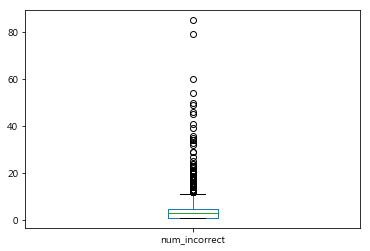

In [93]:
# boxplot 
train_labels_df.loc[train_labels_df.num_correct ==0,'num_incorrect'].plot.box()

In [94]:
# describe
train_labels_df.loc[train_labels_df.num_correct ==0,'num_incorrect'].describe()

count    4229.000000
mean        3.865689
std         4.441508
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        85.000000
Name: num_incorrect, dtype: float64

### 정답을 맞춘 경우
* 맞추지 못한 경우보다 max값의 크기가 반으로 줄었다

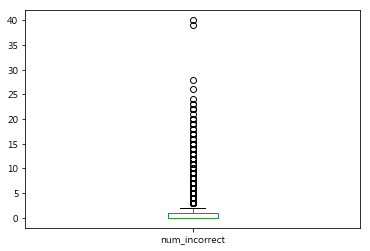

In [95]:
# boxplot 
train_labels_df.loc[train_labels_df.num_correct ==1,'num_incorrect'].plot.box()

In [96]:
# describe
train_labels_df.loc[train_labels_df.num_correct ==1,'num_incorrect'].describe()

count    13461.000000
mean         0.872149
std          1.988170
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         40.000000
Name: num_incorrect, dtype: float64

### accuracy_group

In [97]:
train_labels_df.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [98]:
train_labels_df.groupby('accuracy_group')['accuracy','num_incorrect'].mean()

,accuracy,num_incorrect
accuracy_group,,
0,0.000000,3.865689
1,0.245702,3.954791
2,0.500000,1.000000
3,1.000000,0.000000


#### title별 accuracy_group
* Bird Measurer가 통계적으로는 가장 어려운 축에 속하며
* Mushroom Sorter는 통계적으로 가장 쉬운 축에 속하는 것으로 보임

In [99]:
df = train_labels_df.groupby(['title','accuracy_group'])['num_incorrect'].agg(['count','sum','mean'])
df1 = df.sum(level=0)
new_cols= list(zip(df1.index.get_level_values(0),['total'] * len(df.index)))
df1.index = pd.MultiIndex.from_tuples(new_cols)
df2 = pd.concat([df,df1]).sort_index()
df2

count   sum       mean
title                        accuracy_group                        
Bird Measurer (Assessment)   0                 886  5283   5.962754
                             1                 778  3626   4.660668
                             2                 389   389   1.000000
                             3                 693     0   0.000000
                             total            2746  9298  11.623422
Cart Balancer (Assessment)   0                 576  1502   2.607639
                             1                 353  1150   3.257790
                             2                 470   470   1.000000
                             3                2752     0   0.000000
                             total            4151  3122   6.865429
Cauldron Filler (Assessment) 0                 421  1643   3.902613
                             1                 459  1561   3.400871
                             2                 630   630   1.000000
                             3                2545     0   0.000000
                             total            4055  3834   8.303484
Chest Sorter (Assessment)    0                1752  6450   3.681507
                             1                 466  2032   4.360515
                             2                 256   256   1.000000
                             3                 507     0   0.000000
                             total            2981  8738   9.042022
Mushroom Sorter (Assessment) 0                 594  1470   2.474747
                             1                 355  1166   3.284507
                             2                 460   460   1.000000
                             3                2348     0   0.000000
                             total            3757  3096   6.759255